# Experiments for lower range of $P_\%$

This notebook runs the model while varying the harvest volume threshold ($V_H$) and planting percentage ($P_\%$).\
All combinations of parameter settings are plotted against eachother and the mean of tree and fungus populations are visualized.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import random
import model as mdl
import warnings

warnings.filterwarnings("ignore")

### Visualization of fungus and tree populations for varying $V_H$ and $P_\%$

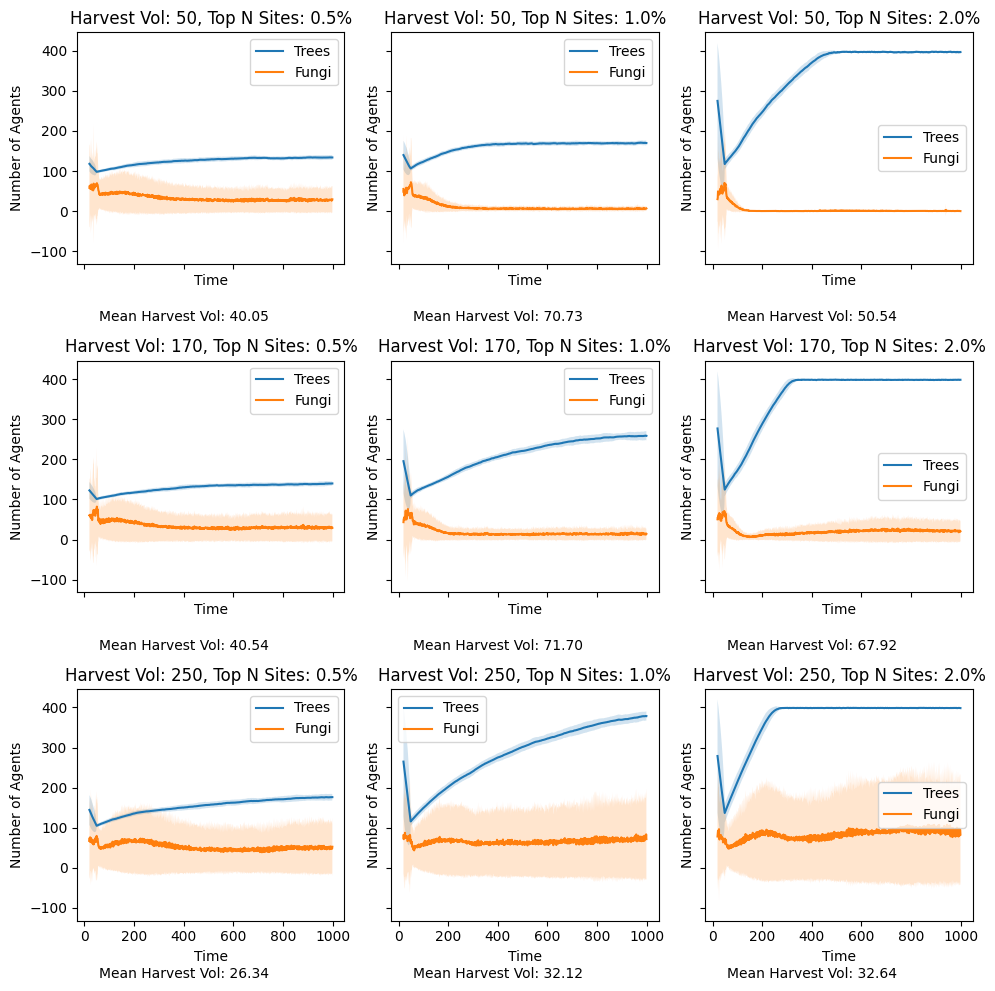

In [7]:
"""
Run 50 simulations for varying V_H and P_% and visualize agent populations
"""
%matplotlib inline

# initial parameter settings
width = 20
height = 20
n_init_trees = 100
n_init_fungi = 50
fert_comp_ratio_exponent = 0.5
max_substrate=3
max_soil_fertility=1

# varying parameters
top_n_sites_percent_values = [0.005, 0.01, 0.02]
harvest_volume_values = [50, 170, 250]

# experimental settings
n_runs = 50
n_steps = 1000
skip_frames = 20
seed = 37
np.random.seed(seed)
random.seed(seed)

# Initialize the model and run it for each combination of parameters
fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=True)

all_data = pd.DataFrame()

for i, top_n_sites_percent in enumerate(top_n_sites_percent_values):
    for j, harvest_volume in enumerate(harvest_volume_values):
        # Update the harvest parameters
        harvest_params = [harvest_volume, 4, 0.5]
        
        runs_data = pd.DataFrame()
        for k in range(n_runs):
            
            # Create and run the model
            model = mdl.Forest(width, height, n_init_trees, n_init_fungi, harvest_params, fert_comp_ratio_exponent, 
                            max_substrate, max_soil_fertility, top_n_sites_percent)        
            model.run_model(n_steps=n_steps)
            
            # Collect the data
            new_data = model.datacollector.get_model_vars_dataframe()
            new_data['Top N Sites Percent'] = top_n_sites_percent
            new_data['Harvest Volume'] = harvest_volume
            new_data['run_id'] = k
            
            runs_data = pd.concat([runs_data,new_data], ignore_index=True)
        
        # Calculate the mean and standard deviation of harvested volume
        harvested_volume_mean = new_data["Harvested volume"].mean()
        # harvested_volume_std = data["Harvested volume"].std()
        
        trees_runs = []
        fungi_runs = []
        
        # Plot each simulation run
        for l in range(n_runs):
            start_idx = l * n_steps + skip_frames
            end_idx = (l + 1) * n_steps
            param_data = runs_data.iloc[start_idx:end_idx].reset_index(drop=True)
            # Store Trees and Fungi data
            trees_runs.append(param_data['Trees'].values)
            fungi_runs.append(param_data['Fungi'].values)
        
        trees_runs = np.array(trees_runs)
        fungi_runs = np.array(fungi_runs)
        
        trees_mean = np.mean(trees_runs, axis=0)
        trees_std = np.std(trees_runs, axis=0)
        fungi_mean = np.mean(fungi_runs, axis=0)
        fungi_std = np.std(fungi_runs, axis=0)
        
        x_values = range(skip_frames, len(param_data)+skip_frames)
        axes[j,i].plot(x_values, trees_mean, label="Trees")
        axes[j,i].plot(x_values, fungi_mean, label="Fungi")
        
        axes[j,i].fill_between(x_values, trees_mean - trees_std, trees_mean + trees_std, alpha=0.2)
        axes[j,i].fill_between(x_values, fungi_mean - fungi_std, fungi_mean + fungi_std, alpha=0.2)

        # # Plot the data starting from the 50th time step
        ax = axes[j, i]
        ax.legend()
        ax.set_title(f'Harvest Vol: {harvest_volume}, Top N Sites: {top_n_sites_percent * 100}%')
        ax.set_xlabel('Time')
        ax.set_ylabel('Number of Agents')
        
        # Print the mean and standard deviation below the plot
        textstr = '\n'.join((
            f'Mean Harvest Vol: {harvested_volume_mean:.2f}',
        ))
        ax.text(0.4, -0.2, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='center')

        all_data = pd.concat([all_data, runs_data], ignore_index=True)
        
plt.tight_layout()
plt.show()

# Write parquet file
table = pa.Table.from_pandas(all_data)
pq.write_table(table, f'param_experiments_seed{seed}.parquet')